In [141]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader, Subset
import networkx as nx
import random
import math
import torch.nn.functional as F

In [142]:
# Device configuration
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

num_agents = 10
epochs = 1000  # Adjusted for demonstration
initial_learning_rate = 0.001
batch_size = 64

# Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# Shuffle and divide data
indices = np.random.permutation(len(dataset))
split_indices = np.array_split(indices, num_agents)
subsets = [Subset(dataset, idx) for idx in split_indices]
dataloaders = [DataLoader(subset, batch_size=batch_size, shuffle=True) for subset in subsets]

Using device: mps


In [143]:
def initialize_and_make_doubly_stochastic(num_agents, initial_graph_type="erdos_renyi", erdos_renyi_prob=0.8,
                                          tol=1e-5, max_iters=1000, device='cpu'):
    if initial_graph_type == "erdos_renyi":
        G = nx.erdos_renyi_graph(num_agents, erdos_renyi_prob)
        while not nx.is_connected(G):
            G = nx.erdos_renyi_graph(num_agents, erdos_renyi_prob)
    elif initial_graph_type == "complete":
        G = nx.complete_graph(num_agents)
    else:
        print(f"Error: Invalid initial_graph_type: {initial_graph_type}")
        return None, None

    adj_matrix = nx.adjacency_matrix(G).toarray()

    def _make_doubly_stochastic(matrix, tol, max_iters):
        A = matrix.copy().astype(np.float64)
        for _ in range(max_iters):
            new_A = A.copy()
            row_sums = new_A.sum(axis=1)
            if np.any(row_sums == 0):
                new_A[row_sums == 0, :] = 1 / new_A.shape[1]
                row_sums = new_A.sum(axis=1)
            new_A = new_A / row_sums[:, np.newaxis]
            col_sums = new_A.sum(axis=0)
            if np.any(col_sums == 0):
                new_A[:, col_sums == 0] = 1 / new_A.shape[0]
                col_sums = new_A.sum(axis=0)
            new_A = new_A / col_sums
            if np.allclose(new_A.sum(axis=1), 1, atol=tol) and np.allclose(new_A.sum(axis=0), 1, atol=tol):
                return new_A
            A = new_A
        print("Warning: Sinkhorn-Knopp did not converge within max_iters.")
        return A

    W = _make_doubly_stochastic(adj_matrix, tol, max_iters)
    W_tensor = torch.tensor(W, dtype=torch.float32).to(device)
    print(nx.adjacency_matrix(G).toarray())
    print(W_tensor)
    return G, W_tensor

In [144]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

    def initialize_far_from_optimal(self):
    # Initialize weights with a larger standard deviation
        for m in self.modules():
            if isinstance(m, (nn.Conv2d, nn.Linear)):
                nn.init.normal_(m.weight, mean=0, std=1)  # Larger std
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)


def time_varying_graph(G, t, change_prob=0.3, tol=1e-5, max_iters=10000, device='cpu'):
    if t > 0:
        edges = list(G.edges())
        for edge in edges:
            if random.random() < change_prob:
                G.remove_edge(*edge)
        while not nx.is_connected(G):
            u, v = random.sample(range(G.number_of_nodes()), 2)
            G.add_edge(u, v)

    adj_matrix = nx.adjacency_matrix(G).toarray()
    print(f"Adjacency Matrix at t={t}:\n", adj_matrix)

    def _make_doubly_stochastic(matrix, tol, max_iters):
        A = matrix.copy().astype(np.float64)
        for _ in range(max_iters):
            new_A = A.copy()
            row_sums = new_A.sum(axis=1)
            if np.any(row_sums == 0):
                new_A[row_sums == 0, :] = 1 / new_A.shape[1]
                row_sums = new_A.sum(axis=1)
            new_A = new_A / row_sums[:, np.newaxis]
            col_sums = new_A.sum(axis=0)
            if np.any(col_sums == 0):
                new_A[:, col_sums == 0] = 1 / new_A.shape[0]
                col_sums = new_A.sum(axis=0)
            new_A = new_A / col_sums
            if np.allclose(new_A.sum(axis=1), 1, atol=tol) and np.allclose(new_A.sum(axis=0), 1, atol=tol):
                return new_A
            A = new_A
        print("Warning: Sinkhorn-Knopp did not converge within max_iters.")
        return A

    W = _make_doubly_stochastic(adj_matrix, tol, max_iters)
    print(f"Doubly Stochastic Matrix at t={t}:\n", W)
    W_tensor = torch.tensor(W, dtype=torch.float32).to(device)
    return G, W_tensor


In [145]:
def run_model(epochs, num_agents, losses, models, criterions, initial_learning_rate, use_time_varying_graph=False):
    if use_time_varying_graph:
        G, W = initialize_and_make_doubly_stochastic(num_agents, device=device)
    else:
        G, W = initialize_and_make_doubly_stochastic(num_agents, device=device)

    for epoch in range(epochs):
        if use_time_varying_graph:
            G, W = time_varying_graph(G, epoch, device=device)

        new_params = {}
        for i in range(num_agents):
            new_params[i] = {name: torch.zeros_like(param) for name, param in models[i].named_parameters()}
            for name, param in models[i].named_parameters():
                for j in range(num_agents):
                    new_params[i][name] += W[i, j] * models[j].state_dict()[name]

        for i in range(num_agents):
            for name, param in models[i].named_parameters():
                param.data.copy_(new_params[i][name])

        # learning_rate = initial_learning_rate / (1 + math.log(max(1, epoch)**0.5))
        learning_rate = initial_learning_rate

        for i in range(num_agents):
            running_loss = 0.0
            for images, labels in dataloaders[i]:
                images, labels = images.to(device), labels.to(device)
                outputs = models[i](images)
                loss = criterions[i](outputs, labels)
                loss.backward()

                with torch.no_grad():
                    for param in models[i].parameters():
                        param -= learning_rate * param.grad
                    for param in models[i].parameters():
                        param.grad.zero_()

                running_loss += loss.item()
            losses[i].append(running_loss / len(dataloaders[i]))
            print(f"Agent {i+1}, Epoch {epoch+1}, Loss: {running_loss / len(dataloaders[i])}, LR: {learning_rate}")

In [146]:
def get_loss_function(agent_id, num_agents):
    if agent_id % 2 == 0:
        return nn.CrossEntropyLoss()
    else:
        return nn.MSELoss()  

In [147]:
if __name__ == '__main__':
    models = [CNN().to(device) for _ in range(num_agents)]
    for model in models:
        model.initialize_far_from_optimal()

    criterions = [nn.CrossEntropyLoss() for i in range(num_agents)]

    losses = [[] for _ in range(num_agents)]
    use_time_varying_graph = False

    run_model(epochs, num_agents, losses, models, criterions, initial_learning_rate, use_time_varying_graph)

/var/folders/jj/yj1r8p1s23sgk5x98428488r0000gn/T/ipykernel_1829/2019690034.py:13: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj_matrix = nx.adjacency_matrix(G).toarray()
/var/folders/jj/yj1r8p1s23sgk5x98428488r0000gn/T/ipykernel_1829/2019690034.py:37: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  print(nx.adjacency_matrix(G).toarray())


[[0 1 0 1 1 0 1 1 1 1]
 [1 0 1 1 1 1 1 1 1 0]
 [0 1 0 1 0 1 1 0 1 1]
 [1 1 1 0 1 0 1 1 1 1]
 [1 1 0 1 0 1 1 1 1 1]
 [0 1 1 0 1 0 1 0 1 1]
 [1 1 1 1 1 1 0 1 1 1]
 [1 1 0 1 1 0 1 0 1 1]
 [1 1 1 1 1 1 1 1 0 0]
 [1 0 1 1 1 1 1 1 0 0]]
tensor([[0.0000, 0.1358, 0.0000, 0.1414, 0.1414, 0.0000, 0.1200, 0.1738, 0.1358,
         0.1519],
        [0.1358, 0.0000, 0.1539, 0.1104, 0.1104, 0.1539, 0.0938, 0.1358, 0.1060,
         0.0000],
        [0.0000, 0.1539, 0.0000, 0.1603, 0.0000, 0.2235, 0.1361, 0.0000, 0.1539,
         0.1722],
        [0.1414, 0.1104, 0.1603, 0.0000, 0.1150, 0.0000, 0.0976, 0.1414, 0.1104,
         0.1235],
        [0.1414, 0.1104, 0.0000, 0.1150, 0.0000, 0.1603, 0.0976, 0.1414, 0.1104,
         0.1235],
        [0.0000, 0.1539, 0.2235, 0.0000, 0.1603, 0.0000, 0.1361, 0.0000, 0.1539,
         0.1722],
        [0.1200, 0.0938, 0.1361, 0.0976, 0.0976, 0.1361, 0.0000, 0.1200, 0.0938,
         0.1049],
        [0.1738, 0.1358, 0.0000, 0.1414, 0.1414, 0.0000, 0.1200, 0.0000, 0.1

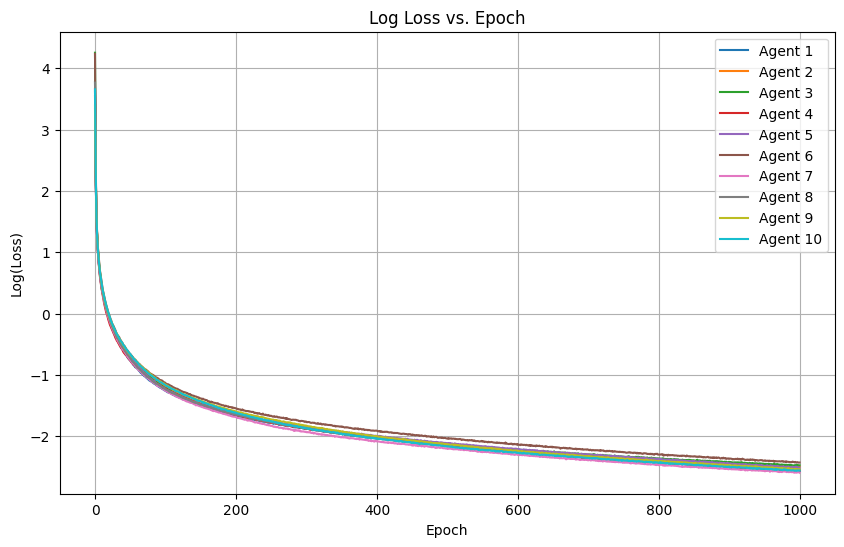

In [149]:
plt.figure(figsize=(10, 6))  
for i in range(num_agents):
    plt.plot(np.log(losses[i]), label=f"Agent {i+1}")  # Apply log *here*

plt.xlabel("Epoch")
plt.ylabel("Log(Loss)")  
plt.title("Log Loss vs. Epoch")
plt.legend()
plt.grid(True)  
plt.show()

plot, step size decay, initalization 

In [150]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader, Subset
import networkx as nx
import random
import math
import torch.nn.functional as F

# Device configuration
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

num_agents = 10
epochs = 1000
initial_learning_rate = 0.0003  # Reduced learning rate for stability
batch_size = 64

# Load MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])
dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
val_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Split data among agents (simple splitting for stability)
indices = list(range(len(dataset)))
random.shuffle(indices)
split_indices = np.array_split(indices, num_agents)
subsets = [Subset(dataset, idx) for idx in split_indices]
dataloaders = [DataLoader(subset, batch_size=batch_size, shuffle=True) for subset in subsets]

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # Simplified architecture for stability
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

    def initialize_weights(self):
        # Use more conservative initialization
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight, gain=0.1)  # Smaller gain for stability
                nn.init.constant_(m.bias, 0)

def initialize_mixing_matrix(num_agents, device='cpu'):
    """Create a simple, stable doubly stochastic mixing matrix"""
    # Create a complete graph for maximum stability
    W = np.ones((num_agents, num_agents)) / num_agents
    
    # Verify double stochasticity
    row_sums = np.sum(W, axis=1)
    col_sums = np.sum(W, axis=0)
    print(f"Row sums: min={min(row_sums):.6f}, max={max(row_sums):.6f}")
    print(f"Col sums: min={min(col_sums):.6f}, max={max(col_sums):.6f}")
    
    return torch.tensor(W, dtype=torch.float32).to(device)

def evaluate_model(model, data_loader, device):
    """Evaluate model accuracy"""
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    return 100 * correct / total

def clip_gradients(model, max_norm=1.0):
    """Apply gradient clipping to prevent exploding gradients"""
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)

def run_decentralized_learning(epochs, num_agents, dataloaders, val_loader, device, 
                               lr=0.0003, weight_decay=1e-4, max_grad_norm=1.0):
    """Run decentralized learning with robust implementations"""
    # Initialize models
    models = [CNN().to(device) for _ in range(num_agents)]
    for model in models:
        model.initialize_weights()
    
    # Use conservative optimizers
    optimizers = [torch.optim.SGD(models[i].parameters(), 
                                  lr=lr, 
                                  momentum=0.9,
                                  weight_decay=weight_decay) for i in range(num_agents)]
    
    # Use step learning rate scheduler
    schedulers = [torch.optim.lr_scheduler.StepLR(optimizers[i], 
                                                step_size=30, 
                                                gamma=0.5) for i in range(num_agents)]
    
    # Loss function - Cross Entropy for all models
    criterions = [nn.CrossEntropyLoss() for _ in range(num_agents)]
    
    # Initialize metrics tracking
    train_losses = [[] for _ in range(num_agents)]
    val_accuracies = [[] for _ in range(num_agents)]
    consensus_metrics = []
    
    # Initialize mixing matrix - use complete graph for stability
    W = initialize_mixing_matrix(num_agents, device)
    
    # Training loop
    for epoch in range(epochs):
        # Local training step
        for i in range(num_agents):
            models[i].train()
            running_loss = 0.0
            
            for images, labels in dataloaders[i]:
                images, labels = images.to(device), labels.to(device)
                
                # Forward pass
                outputs = models[i](images)
                loss = criterions[i](outputs, labels)
                
                # Backward and optimize with gradient clipping
                optimizers[i].zero_grad()
                loss.backward()
                # clip_gradients(models[i], max_grad_norm)  # Apply gradient clipping
                optimizers[i].step()
                
                # Check for NaN values in model parameters
                if any(torch.isnan(param).any() for param in models[i].parameters()):
                    print(f"NaN detected in Agent {i+1} parameters after backward step")
                    # Reinitialize the model if needed
                    models[i] = CNN().to(device)
                    models[i].initialize_weights()
                    optimizers[i] = torch.optim.SGD(models[i].parameters(), lr=lr, momentum=0.9, weight_decay=weight_decay)
                    break
                
                running_loss += loss.item()
            
            # Store loss safely
            epoch_loss = running_loss / len(dataloaders[i])
            if not np.isnan(epoch_loss) and not np.isinf(epoch_loss):
                train_losses[i].append(epoch_loss)
            else:
                if len(train_losses[i]) > 0:
                    train_losses[i].append(train_losses[i][-1])  # Use previous loss
                else:
                    train_losses[i].append(10.0)  # Default value
                print(f"Warning: Agent {i+1} has invalid loss value at epoch {epoch+1}")
            
            # Update learning rate
            schedulers[i].step()
        
        # Consensus step - carefully implement parameter averaging
        with torch.no_grad():
            # Safe parameter averaging
            param_dict = {i: {} for i in range(num_agents)}
            
            # First collect all parameters
            for i, model in enumerate(models):
                for name, param in model.named_parameters():
                    param_dict[i][name] = param.data.clone()
            
            # Perform weighted average for each parameter
            for i, model in enumerate(models):
                for name, param in model.named_parameters():
                    aggregated_param = torch.zeros_like(param.data)
                    
                    for j in range(num_agents):
                        # Skip models with NaN parameters
                        if torch.isnan(param_dict[j][name]).any():
                            continue
                        aggregated_param += W[i, j] * param_dict[j][name]
                    
                    # Check for NaN before updating
                    if not torch.isnan(aggregated_param).any():
                        param.data.copy_(aggregated_param)
        
        # Evaluate and log (every 10 epochs)
        if epoch % 10 == 0 or epoch == epochs - 1:
            # Calculate consensus metric safely
            param_variance = 0.0
            param_count = 0
            
            # Get flattened parameters
            flattened_params = []
            for model in models:
                agent_params = []
                for name, param in model.named_parameters():
                    if not torch.isnan(param).any():
                        agent_params.append(param.data.flatten())
                
                if agent_params:
                    flattened_params.append(torch.cat(agent_params))
            
            # Calculate variance if we have valid parameters
            if flattened_params:
                stacked_params = torch.stack(flattened_params)
                param_variance = torch.var(stacked_params, dim=0).mean().item()
                
            consensus_metrics.append(param_variance)
            print(f"Epoch {epoch+1}, Consensus metric: {param_variance:.6f}")
            
            # Evaluate all agents
            for i, model in enumerate(models):
                if not any(torch.isnan(param).any() for param in model.parameters()):
                    accuracy = evaluate_model(model, val_loader, device)
                    val_accuracies[i].append(accuracy)
                    print(f"Agent {i+1}, Epoch {epoch+1}, Loss: {train_losses[i][-1]:.4f}, Val Acc: {accuracy:.2f}%")
                else:
                    if val_accuracies[i]:
                        val_accuracies[i].append(val_accuracies[i][-1])
                    else:
                        val_accuracies[i].append(0.0)
                    print(f"Agent {i+1}, Epoch {epoch+1}, Loss: {train_losses[i][-1]:.4f}, Val Acc: N/A (NaN params)")
    
    return train_losses, val_accuracies, consensus_metrics

# Main execution
if __name__ == '__main__':
    print(f"Running decentralized learning with {num_agents} agents for {epochs} epochs")
    
    # Run with conservative hyperparameters
    train_losses, val_accuracies, consensus_metrics = run_decentralized_learning(
        epochs=epochs,
        num_agents=num_agents,
        dataloaders=dataloaders,
        val_loader=val_loader,
        device=device,
        lr=0.0003,  # Lower learning rate
        weight_decay=1e-4,
        max_grad_norm=1.0  # Strict gradient clipping
    )
    


Using device: mps
Running decentralized learning with 10 agents for 1000 epochs
Row sums: min=1.000000, max=1.000000
Col sums: min=1.000000, max=1.000000
Epoch 1, Consensus metric: 0.000000
Agent 1, Epoch 1, Loss: 2.3010, Val Acc: 11.35%
Agent 2, Epoch 1, Loss: 2.3013, Val Acc: 11.35%
Agent 3, Epoch 1, Loss: 2.3009, Val Acc: 11.35%
Agent 4, Epoch 1, Loss: 2.3014, Val Acc: 11.35%
Agent 5, Epoch 1, Loss: 2.3015, Val Acc: 11.35%
Agent 6, Epoch 1, Loss: 2.3012, Val Acc: 11.35%
Agent 7, Epoch 1, Loss: 2.3006, Val Acc: 11.35%
Agent 8, Epoch 1, Loss: 2.2998, Val Acc: 11.35%
Agent 9, Epoch 1, Loss: 2.3001, Val Acc: 11.35%
Agent 10, Epoch 1, Loss: 2.3012, Val Acc: 11.35%


KeyboardInterrupt: 

In [ ]:
# Plot results
plt.figure(figsize=(15, 10))
    
# Plot 1: Training loss (safe plotting)
plt.subplot(2, 2, 1)
for i in range(num_agents):
# Filter out extreme values
    safe_losses = np.array(train_losses[i])
    safe_losses = np.clip(safe_losses, 0, 10)  # Clip to reasonable range
    plt.plot(safe_losses, label=f"Agent {i+1}")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss") plt.legend()
plt.grid(True)
    
# Plot 2: Validation accuracy
plt.subplot(2, 2, 2)
eval_points = list(range(0, epochs, 10)) + ([epochs-1] if (epochs-1) % 10 != 0 else [])
for i in range(num_agents):
    plt.plot(eval_points, val_accuracies[i], marker='o', label=f"Agent {i+1}")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.title("Validation Accuracy")
    plt.legend()
    plt.grid(True)
    
    # Plot 3: Consensus metric
    plt.subplot(2, 2, 3)
    plt.plot(eval_points, consensus_metrics, marker='o')
    plt.xlabel("Epoch")
    plt.ylabel("Parameter Variance")
    plt.title("Consensus Metric")
    plt.grid(True)
    
     # Plot 4: Final model comparison
    plt.subplot(2, 2, 4)
    final_accuracies = [val_accuracies[i][-1] for i in range(num_agents)]
    plt.bar(range(1, num_agents+1), final_accuracies)
    plt.xlabel("Agent")
    plt.ylabel("Final Accuracy (%)")
    plt.title("Final Model Performance")
    plt.xticks(range(1, num_agents+1))
    plt.grid(True, axis='y')
        
    plt.tight_layout()
    plt.savefig("decentralized_learning_results.png")
    plt.show()